<a href="https://colab.research.google.com/github/ghtaro/Fashion_MNIST/blob/master/Fashion_MNIST_DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import sys
import math
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [0]:
gd_mount_path = '/content/drive'
from google.colab import drive
drive.mount(gd_mount_path)

In [0]:
gd_root_path = '/content/drive/My Drive/Colab Notebooks/Fashion_MNIST/'
gd_material_path = os.path.join(gd_root_path, 'material')
gd_data_path = os.path.join(gd_root_path, 'data')
gd_output_path = os.path.join(gd_root_path, 'output/MLP_TF')

gd_utils_path = '/content/drive/My Drive/Colab Notebooks/Utils'
gd_pictures_path = '/content/drive/My Drive/Colab Notebooks/Pictures'

sys.path.append(gd_utils_path)
try:
    del sys.modules['tool']
    del sys.modules['tool_mlp']
except Exception as e:
    pass
import tool
import tool_mlp

In [0]:
x_train, y_train, x_test = tool.load_fashionmnist(gd_data_path)
x_sample, y_sample = shuffle(x_train, y_train)
x_sample, y_sample = x_sample[:5000], y_sample[:5000]

# PCA

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3) # 3次元に圧縮
x_pca = pca.fit_transform(x_sample) # データのセンタリングは、自動的にされている。

PCA1,2,3の画像を出力。なんだかよくわからんし、き、気持ち悪い。。。

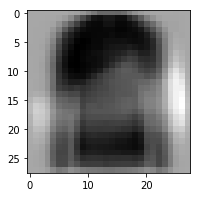

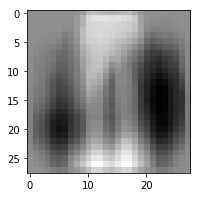

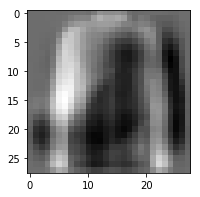

In [0]:
tool.show_image(pca.components_.T[:, 0], s=3)
tool.show_image(pca.components_.T[:, 1], s=3)
tool.show_image(pca.components_.T[:, 2], s=3)


In [0]:
def plot2d_pca(x_pca, y, d1, d2, N, figsize, x_range, y_range, title):
    # setup the plot
    fig, ax = plt.subplots(1,1, figsize=figsize)
    tag = y.argmax(axis=1) # Tag each point with a corresponding label    

    # define the colormap
    cmap = plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize
    bounds = np.linspace(0, N, N+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    # make the scatter
    scat = ax.scatter(x_pca[:, d1], x_pca[:, d2], c=tag, cmap=cmap, norm=norm)
    # create the colorbar
    cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
    cb.set_label('Custom cbar')
    ax.set_title(title)
    ax.set_xlabel('PCA' + str(d1+1))
    ax.set_ylabel('PCA' + str(d2+1))
    
    plt.xlim(x_range[0], x_range[1])
    plt.ylim(y_range[0], y_range[1])
    plt.show()

- クラス５（サンダル）とクラス７（スニーカー）はPCA１が小さい。
    - PCA1は肩の位置、あるいは、腰の位置に、重みをもつ。
    - サンダル、スニーカーは靴で、ちょうど肩、腰の間（胸の部分）にだけ画像が来るので、PCA１に感度を持たない。よって、PCA1が極端に小さくなり、他と区別できる。

- PCA2: クラス１（ズボン）を分類できそう
    - このクラスだけPCA2が非常に小さい。
    - 理由は、ズボンの画像はx軸方向で見て、中央部分に偏っている。PCA2は、x軸中央には重みがない（白い）。だから、ズボンはPCA2に感度を持たず、他のクラスとの差別化ができる。
    - 同じ理由で、クラス３（ドレス）も、ズボンほどではないが、小さなPCA2を持ち、他と区別できる。

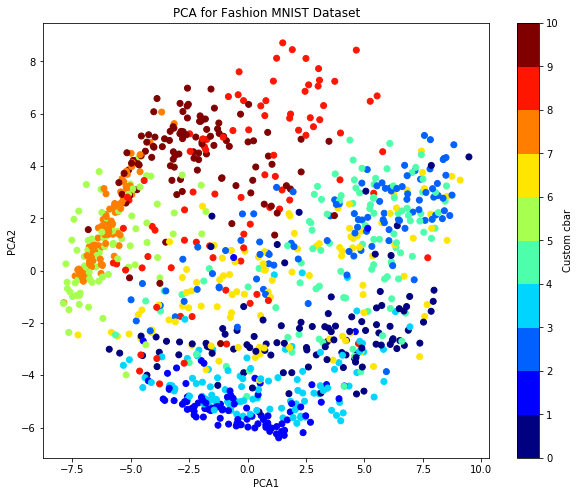

In [0]:
plot2d_pca(x_pca, y_sample, d1=0, d2=1, N=10, figsize=(10,8), title='PCA for Fashion MNIST Dataset')

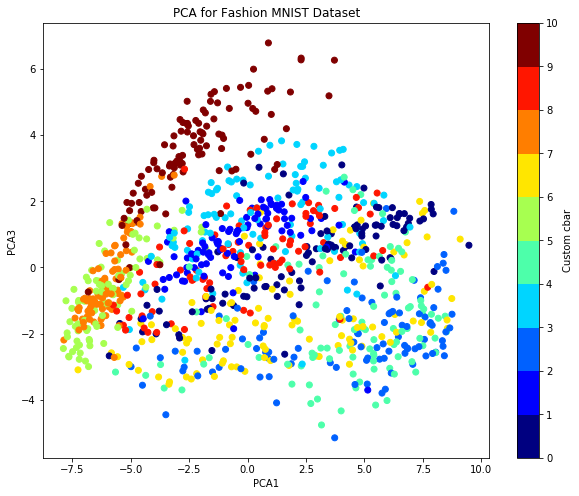

In [0]:
plot2d_pca(x_pca, y_sample, d1=0, d2=2, N=10, figsize=(10,8), title='PCA for Fashion MNIST Dataset')

- クラス9（アンクルブーツ）は、PCA2とPCA3で分類できそう。
    - 特にPCA3が大きい。理由は、なぜかPCA3はアンクルブーツの形をしているから。
- クラス８（バッグ）はPCA２で分類できそう。
    - 例外もあるが、PCA2が大きい。理由は、PCA2は、服の脇下の部分（横っ腹の部分で、服画像では空欄となることが多い）に重みがあり、バッグだけ（アンクルブーツも若干）、そこらへんもカバーしているからに見える。


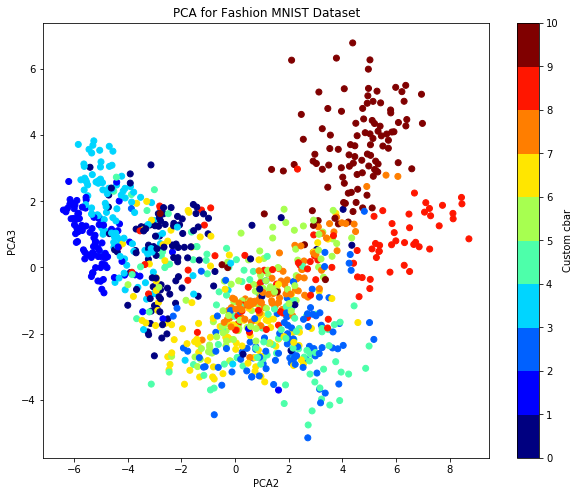

In [0]:
plot2d_pca(x_pca, y_sample, d1=1, d2=2, N=10, figsize=(10,8), title='PCA for Fashion MNIST Dataset')

最後に因子寄与率を求める。第３主成分まで足しても、50％程度なので、PCAがあまりフィットしていないように見える。
- PCA1: 29%
- PCA2: 17%
- PCA3: 6%

In [0]:
print(pca.explained_variance_ratio_)

[0.29403594 0.17866917 0.06297641]


因子寄与率が合計で95%となる次数を求める。137次元らしい。

**Q1. 137次元のPCA使えば、95％精度の分類モデルができるということだろうか？**

137


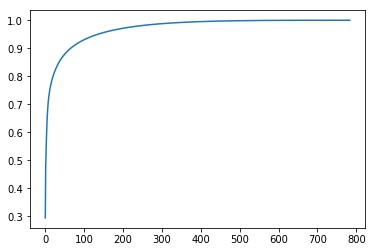

In [0]:
pca = PCA()
pca.fit(x_sample)
cumsum = np.cumsum(pca.explained_variance_ratio_)
print(np.argmax(cumsum >= 0.95) + 1)
plt.plot(range(784), cumsum)

# kernel PCA

クラス０、２、３、４、６は、上記のPCAではクラスタリングが難しいように見える。

そこで、非線形次元圧縮手法であるkPCAを試す。まず、Grid Search CVして、最適なHyper parameterを見つける。

**Q2. kPCAで分類できれば、kSVMを分類モデルとして使えば、よい精度が出るということか？**

In [0]:
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('kpca', KernelPCA(n_components=3)),
    ('log_clf', LogisticRegression())
]
)

param_grid = [{
    'kpca__gamma': np.linspace(0.03, 0.05, 10),
    'kpca__kernel': ['rbf', 'sigmoid']
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(x_sample, y_sample.argmax(axis=1))

In [0]:
print(grid_search.best_params_)

{'kpca__gamma': 0.03, 'kpca__kernel': 'rbf'}


In [0]:
rbf_pca = KernelPCA(n_components=3, kernel='rbf', gamma=0.03)
x_rbf = rbf_pca.fit_transform(x_sample)

以下、kPCA1,2,3の2次元プロットを出力。

- 結果としては、やはりクラス２，４，６を分類できていない。
- これの意味することは？→「kSVM(RBF kernel)でも、うまく分類できないから、他の手法を試さないといけないよ」と言っているのか？？

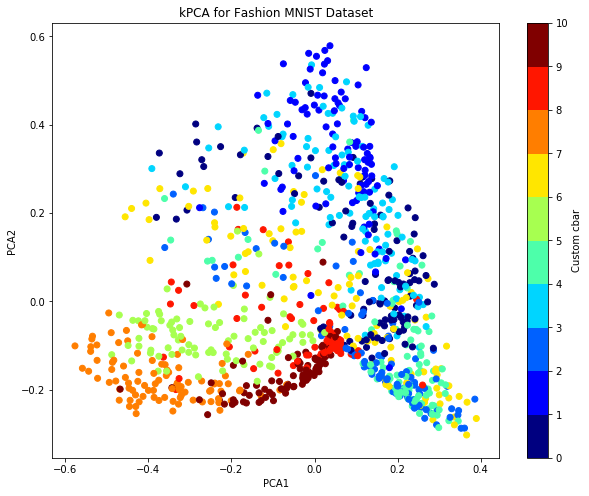

In [0]:
plot2d_pca(x_rbf, y_sample, d1=0, d2=1, N=10, figsize=(10,8), title='kPCA for Fashion MNIST Dataset')

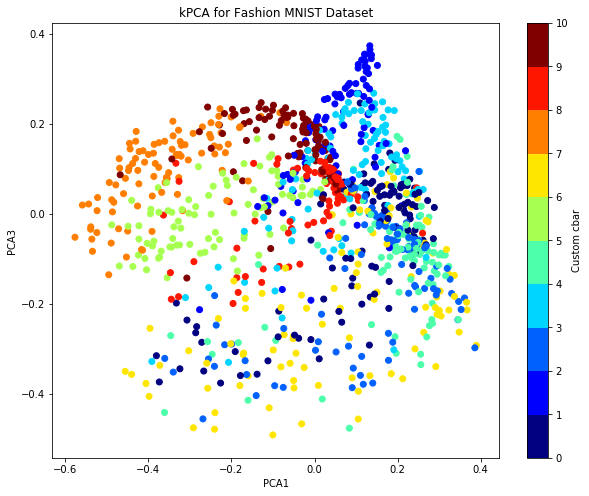

In [0]:
plot2d_pca(x_rbf, y_sample, d1=0, d2=2, N=10, figsize=(10,8), title='kPCA for Fashion MNIST Dataset')

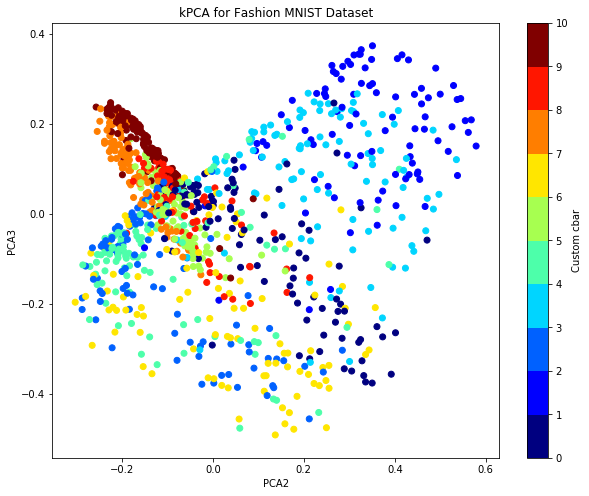

In [0]:
plot2d_pca(x_rbf, y_sample, d1=1, d2=2, N=10, figsize=(10,8), title='kPCA for Fashion MNIST Dataset')

最後にt-SNEを使ってみる。１、2次元目のプロット（最初のグラフ）を見ると、改善はしているようだ。
- クラス４とクラス６は、分類できているように見える。
- クラス２と４、クラス２と６が、若干ミックスされている。

この結果が意味することは、「クラス２，４，６をはっきり分類するのは至難の業」ということだろうか。。。

In [0]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42, n_components=3)
x_tsne = tsne.fit_transform(x_sample)

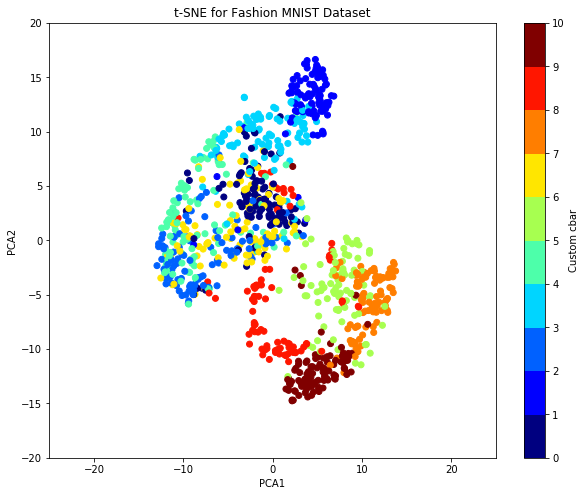

In [0]:
plot2d_pca(x_tsne, y_sample, d1=0, d2=1, N=10, figsize=(10,8), x_range=(-25,25), y_range=(-20,20), title='t-SNE for Fashion MNIST Dataset')

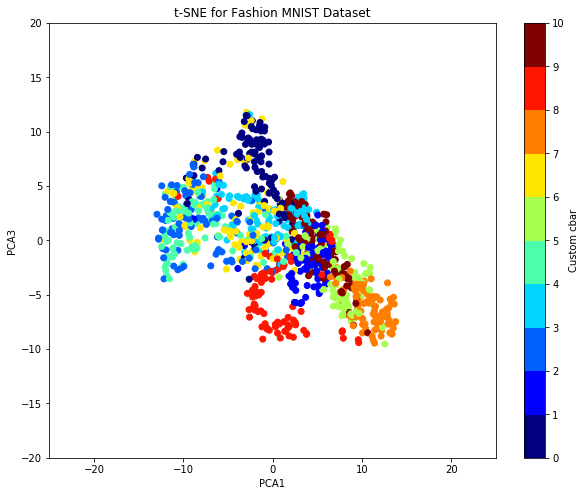

In [0]:
plot2d_pca(x_tsne, y_sample, d1=0, d2=2, N=10, figsize=(10,8), x_range=(-25,25), y_range=(-20,20), title='t-SNE for Fashion MNIST Dataset')

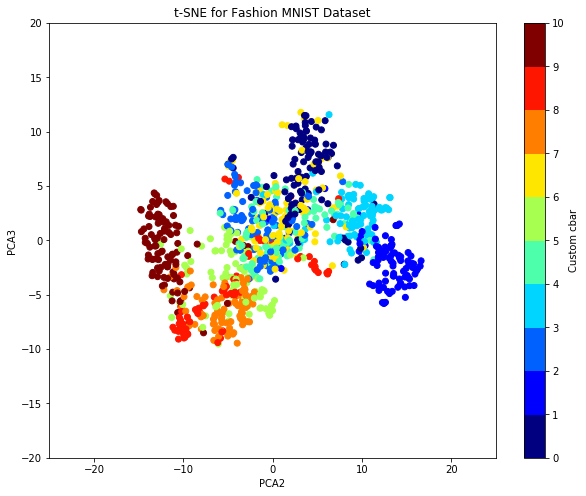

In [0]:
plot2d_pca(x_tsne, y_sample, d1=1, d2=2, N=10, figsize=(10,8), x_range=(-25,25), y_range=(-20,20), title='t-SNE for Fashion MNIST Dataset')